# AQT Optimizations with Qiskit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/aqt/aqt_qss.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/aqt/aqt_qss.ipynb)

Superstaq can be interfaced via Qiskit by instantiating a provider in qiskit-superstaq:

In [1]:
from numpy import pi as π
import yaml

In [2]:
import qiskit
import qiskit_superstaq

# Instantiate a provider to interface Superstaq via Qiskit:
# Provide your api key to the using the "api_key" argument if
# SUPERSTAQ_API_KEY environment variable is not set.
provider = qiskit_superstaq.SuperstaQProvider()

# Display user balance
provider.get_balance()

'$286.00'

### Single circuit compilation

The primary method for interfacing Superstaq's AQT toolchain is the `aqt_compile` endpoint. As an initial example, we can construct a four-qubit circuit in Qiskit and pass it to Superstaq:

In [3]:
# Construct an example circuit
circuit1 = qiskit.QuantumCircuit(4)
circuit1.h(0)
circuit1.h(1)
circuit1.h(2)
circuit1.h(3)


# Send it to Superstaq
compiler_output = provider.aqt_compile(circuit1)

print(circuit1)

     ┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘


The resulting output contains both the circuit compiled to AQT's native operations, and the corresponding qtrl pulse sequence object. Note that the original circuit was mapped to AQT's four active qubits, and optimized to exploit AQT's virtual Rz gates (as opposed to the canonical Hadamard decomposition requiring two Rx(π/2) and a single Rz(π/2) gate, as described in [1]):

                                      
q_0: ─────────────────────────────────
                                      
q_1: ─────────────────────────────────
                                      
q_2: ─────────────────────────────────
                                      
q_3: ─────────────────────────────────
     ┌─────────┐┌─────────┐┌─────────┐
q_4: ┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     ├─────────┤├─────────┤├─────────┤
q_5: ┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     ├─────────┤├─────────┤├─────────┤
q_6: ┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     ├─────────┤├─────────┤├─────────┤
q_7: ┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     └─────────┘└─────────┘└─────────┘


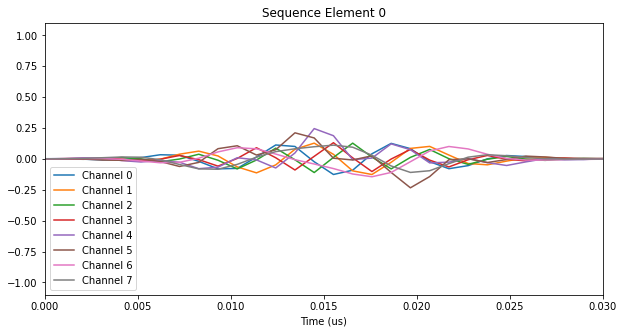

In [4]:
# Print the compiled circuit and pulse sequence
print(compiler_output.circuit)
compiler_output.seq.plot(element=0);

### Multiple circuit compilation

The `aqt_compile` endpoint also allows for the submission of multiple circuits. If passed a list of circuits, each will be individually compiled and the merged into a single qtrl sequence object. Here we construct a second circuit consisting of a single SWAP gate, and pass it to Superstaq along with the circuit constructed above. Note that the compiled SWAP circuit uses the optimized SWAP decomposition outlined in [1], which reduces circuit depth by parallelizing the outer single-qubit gates:



Compiled circuit 1:
                                      
q_0: ─────────────────────────────────
                                      
q_1: ─────────────────────────────────
                                      
q_2: ─────────────────────────────────
                                      
q_3: ─────────────────────────────────
     ┌─────────┐┌─────────┐┌─────────┐
q_4: ┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     ├─────────┤├─────────┤├─────────┤
q_5: ┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     ├─────────┤├─────────┤├─────────┤
q_6: ┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     ├─────────┤├─────────┤├─────────┤
q_7: ┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     └─────────┘└─────────┘└─────────┘


Compiled circuit 2:
                                                                                                                                
q_0: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                   

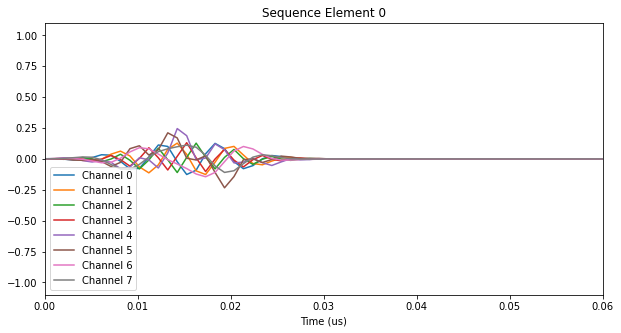

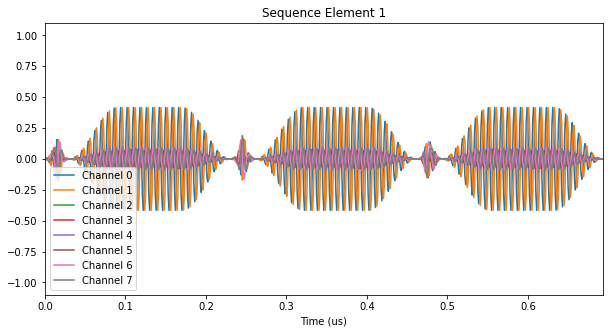

In [5]:
# Construct a SWAP circuit
circuit2 = qiskit.QuantumCircuit(4)
circuit2.swap(0, 1)


# Send both circuits to Superstaq
compiler_output = provider.aqt_compile([circuit1, circuit2])


# Print the compiled circuits and pulse sequences
print("\n\nCompiled circuit 1:")
print(compiler_output.circuits[0])

print("\n\nCompiled circuit 2:")
print(compiler_output.circuits[1].draw(fold=-1))

compiler_output.seq.plot(element=0, t_max=6e-8)
compiler_output.seq.plot(element=1);

### Canonical decompositions

We can also use qiskit's barrier operation to reproduce the canonical (unoptimized) decompositions of the above circuits



Canonical Hadamard circuit:
                                            
q_0: ───────────────────────────────────────
                                            
q_1: ───────────────────────────────────────
                                            
q_2: ───────────────────────────────────────
                                            
q_3: ───────────────────────────────────────
     ┌─────────┐ ░ ┌─────────┐ ░ ┌─────────┐
q_4: ┤ Rx(π/2) ├─░─┤ Rz(π/2) ├─░─┤ Rx(π/2) ├
     ├─────────┤ ░ ├─────────┤ ░ ├─────────┤
q_5: ┤ Rx(π/2) ├─░─┤ Rz(π/2) ├─░─┤ Rx(π/2) ├
     ├─────────┤ ░ ├─────────┤ ░ ├─────────┤
q_6: ┤ Rx(π/2) ├─░─┤ Rz(π/2) ├─░─┤ Rx(π/2) ├
     ├─────────┤ ░ ├─────────┤ ░ ├─────────┤
q_7: ┤ Rx(π/2) ├─░─┤ Rz(π/2) ├─░─┤ Rx(π/2) ├
     └─────────┘ ░ └─────────┘ ░ └─────────┘

Canonical SWAP circuit:
                                                                                                                                                        
q_0: ──────────────────────

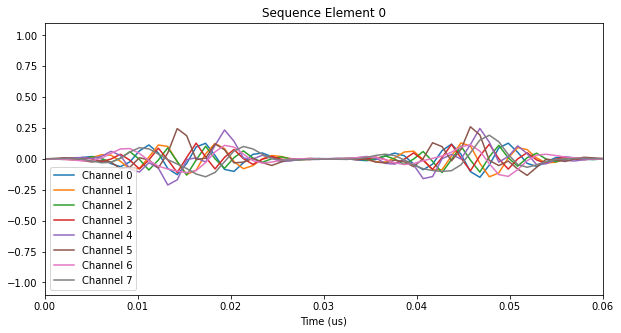

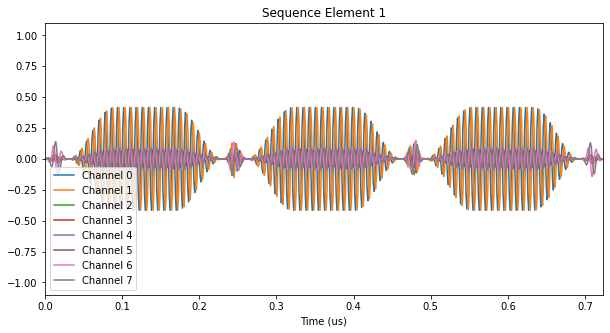

In [6]:
# Construct the above circuits using canonical gate decompositions (Barrier gates added to prevent optimizations)
circuit1 = qiskit.QuantumCircuit(4)
circuit1.rx(π / 2, 0)
circuit1.rx(π / 2, 1)
circuit1.rx(π / 2, 2)
circuit1.rx(π / 2, 3)
circuit1.barrier()
circuit1.rz(π / 2, 0)
circuit1.rz(π / 2, 1)
circuit1.rz(π / 2, 2)
circuit1.rz(π / 2, 3)
circuit1.barrier()
circuit1.rx(π / 2, 0)
circuit1.rx(π / 2, 1)
circuit1.rx(π / 2, 2)
circuit1.rx(π / 2, 3)

circuit2 = qiskit.QuantumCircuit(4)
circuit2.h(0)
circuit2.barrier()
circuit2.cz(0, 1)
circuit2.h(0)
circuit2.h(1)
circuit2.cz(0, 1)
circuit2.h(0)
circuit2.h(1)
circuit2.cz(0, 1)
circuit2.barrier()
circuit2.h(0)


# Send both circuits to Superstaq
compiler_output = provider.aqt_compile([circuit1, circuit2])


# Print the compiled circuits and pulse sequences
print("\n\nCanonical Hadamard circuit:")
print(compiler_output.circuits[0])

print("\nCanonical SWAP circuit:")
print(compiler_output.circuits[1].draw(fold=-1))

compiler_output.seq.plot(element=0, t_max=6e-8)
compiler_output.seq.plot(element=1);

## Configuration

The qtrl pulse sequence returned in the above example was generated using user-specific calibration data. New YAML configuration files can be uploaded to (or retrieved from) Superstaq for each user, which will then be automatically used for all subsequent aqt_compile calls by that user:

In [7]:
# Download and save existing configs from the server (use overwrite=True to overwrite existing files,
# otherwise an error will be thrown if either file already exists locally)

provider.aqt_download_configs("tmp-pulses.yaml", "tmp-variables.yaml", overwrite=True)

In [8]:
# Upload new configs to the server:
provider.aqt_upload_configs("tmp-pulses.yaml", "tmp-variables.yaml")

'Your AQT configuration has been updated'

In [9]:
# Download existing configs as a python dictionary:
configs = provider.aqt_get_configs()

variables = yaml.safe_load(configs["variables"])
print(variables["CS"]["C6T5"])

{'DRAG_alpha': [0.0, 0.0], 'IZ_phase_rad': -1.711, 'L4': {'amplitude': 0.071, 'phase': 0.31}, 'L5': {'amplitude': 0.50326, 'phase': -2.57}, 'L6': {'amplitude': 0.9975, 'phase': 0.14846}, 'L7': {'amplitude': 0.0, 'phase': -1.13}, 'ZI_phase_rad': 2.792, 'amplitude': 0.2892, 'detuning': 0.0, 'envelope': 'cos_square_DRAGdouble', 'length': 1.5e-07, 'mod_freq': -129366659, 'phase': 0.0, 'ramp_fraction': 0.40074, 'ramp_length': None, 'spectator_ZZ': {'L7': {'amplitude': 0.327, 'phase': 0.0}, 'mod_freq': 280000000.0}, 'spectator_phase': {'Q4': 0.038, 'Q7': 2.77}}


## Custom operations

Superstaq is set up to recognize AQT-specific hardware operations if corresponding calibrations exist in the user's configuration data, such as CS/CSD, iToffoli, or optimized calibrations for parallel CZ/CS operations. We've implemented custom gates in each client for operations which do not exist in Cirq or Qiskit:

### iToffoli

The AQT iToffoli operation is defined as an open-control Toffoli gate with an additional CPhase(π/2) on the control state (see [2]):

           
q_0: ──────
           
q_1: ──────
           
q_2: ──────
           
q_3: ──────
           
q_4: ──o───
     ┌─┴──┐
q_5: ┤ Ix ├
     └─┬──┘
q_6: ──o───
           
q_7: ──────
           


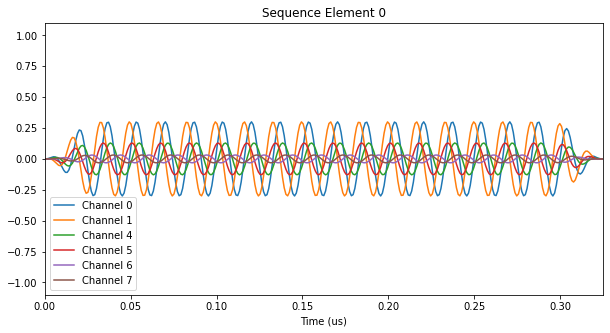

In [10]:
# Instantiate an iToffoli circuit
circuit = qiskit.QuantumCircuit(8)
circuit.append(qiskit_superstaq.AQTiCCXGate(), [4, 6, 5])


# Send it to Superstaq
compiler_output = provider.aqt_compile(circuit)


# Print the compiled circuits and pulse sequences
print(compiler_output.circuit)
compiler_output.seq.plot(element=0);

### CS, CSD, and Simultaneous CZs or CSDs

AQT supports optimized callibrations for controlled partial-rotation CPhase(±π/2) gates as well as parallel CZ and CSD operations [1]. These are inferred automatically via Superstaq's compiler, or can be instantiated directly using qiskit-superstaq's custom `ParallelGates` operation:

                                            ░                                                   
q_0: ───────────────────────────────────────░───────────────────────────────────────────────────
                                            ░                                                   
q_1: ───────────────────────────────────────░───────────────────────────────────────────────────
                                            ░                                                   
q_2: ───────────────────────────────────────░───────────────────────────────────────────────────
                                            ░                                                   
q_3: ───────────────────────────────────────░───────────────────────────────────────────────────
     ┌─────────────────┐┌─────────────────┐ ░    ┌─────────────────┐         ┌─────────────────┐
q_4: ┤0                ├┤0                ├─░────┤0                ├─────────┤0                ├
     │                 ││     

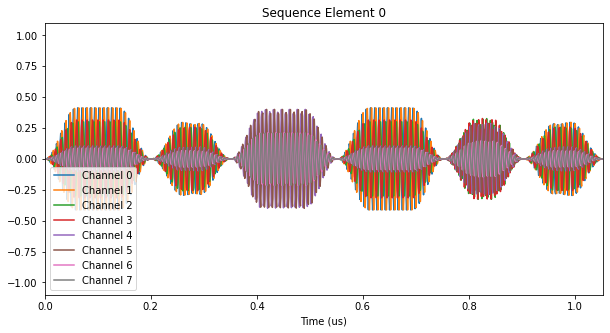

In [11]:
circuit = qiskit.QuantumCircuit(8)

# Directly instantiated parallel operations:
CZ = qiskit.circuit.library.CZGate()
CSD = qiskit.circuit.library.CPhaseGate(-π / 2)
circuit.append(qiskit_superstaq.ParallelGates(CZ, CZ), [4, 5, 6, 7])
circuit.append(qiskit_superstaq.ParallelGates(CSD, CSD), [4, 5, 6, 7])

circuit.barrier()

# Implicitly instantiated parallel operations:
circuit.cz(5, 6)
circuit.cz(4, 5)
circuit.cz(6, 7)
circuit.cp(π / 2, 5, 6)
circuit.cp(-π / 2, 4, 5)
circuit.cp(-π / 2, 6, 7)


# Submit to Superstaq
compiler_output = provider.aqt_compile(circuit)


# Print the compiled circuit and pulse sequence
print(compiler_output.circuit.draw(fold=-1))
compiler_output.seq.plot(element=0);

### ZZ-SWAP gates

Superstaq will attempt to use these operations when compiling other circuits. Here we instantiate a pair of ZZ-SWAP gates, which formed the basis of the work in [1] (also implemented as custom gates in both qiskit-superstaq and cirq-superstaq). Note that in the second example, Superstaq automatically optimizes the ZZ-SWAP(θ) decomposition by using both AQT's CZ and CS/CSD calibrations (which is possible when π/4 < |θ| < 3π/4), and then aligns each to use AQT's calibrations for parallel two-qubit gates:

Input 1:
                     
q_0: ────────────────
                     
q_1: ────────────────
                     
q_2: ────────────────
                     
q_3: ────────────────
                     
q_4: ────────────────
     ┌──────────────┐
q_5: ┤0             ├
     │  Zzswap(2.5) │
q_6: ┤1             ├
     └──────────────┘
q_7: ────────────────
                     

Input 2:
                     
q_0: ────────────────
                     
q_1: ────────────────
                     
q_2: ────────────────
                     
q_3: ────────────────
                     
q_4: ────────────────
     ┌──────────────┐
q_5: ┤0             ├
     │  Zzswap(1.5) │
q_6: ┤1             ├
     └──────────────┘
q_7: ────────────────
                     


Output 1:
                                                                        
q_0: ───────────────────────────────────────────────────────────────────
                                                                        
q_

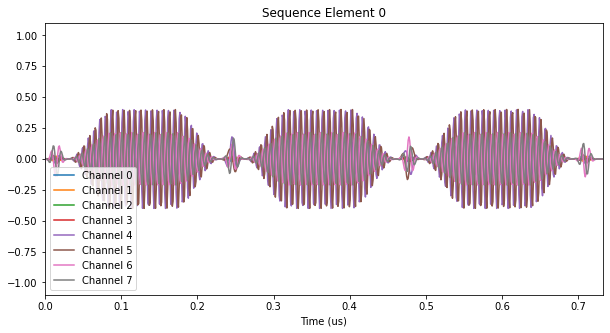

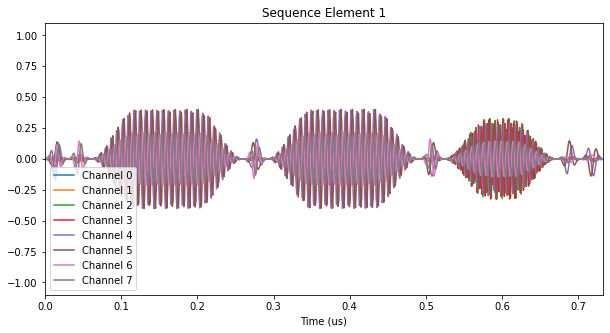

In [12]:
# Construct ZZ-SWAP circuits
circuit1 = qiskit.QuantumCircuit(8)
circuit1.append(qiskit_superstaq.ZZSwapGate(2.5), [5, 6])

circuit2 = qiskit.QuantumCircuit(8)
circuit2.append(qiskit_superstaq.ZZSwapGate(1.5), [5, 6])


print("Input 1:")
print(circuit1)

print("\nInput 2:")
print(circuit2)


# Submit to Superstaq
compiler_output = provider.aqt_compile([circuit1, circuit2])


# Print compiled circuits and pulse sequences
print("\n\nOutput 1:")
print(compiler_output.circuits[0])

print("\nOutput 2:")
print(compiler_output.circuits[1].draw(fold=120))

compiler_output.seq.plot(element=0)
compiler_output.seq.plot(element=1);

Passed pairs of parallel ZZ-SWAPs, Superstaq will also align the CZ and CSD operations to use AQT's parallel calibrations:

Input 1:
     ┌──────────────┐
q_0: ┤0             ├
     │  Zzswap(2.5) │
q_1: ┤1             ├
     ├──────────────┤
q_2: ┤0             ├
     │  Zzswap(2.5) │
q_3: ┤1             ├
     └──────────────┘

Input 2:
     ┌──────────────┐
q_0: ┤0             ├
     │  Zzswap(1.5) │
q_1: ┤1             ├
     ├──────────────┤
q_2: ┤0             ├
     │  Zzswap(1.5) │
q_3: ┤1             ├
     └──────────────┘


Output 1:
                                                                                                                        
q_0: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                        
q_1: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                         

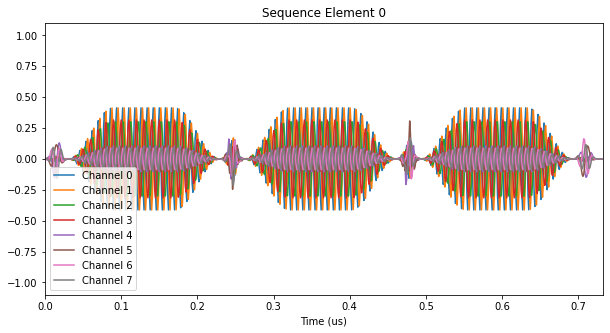

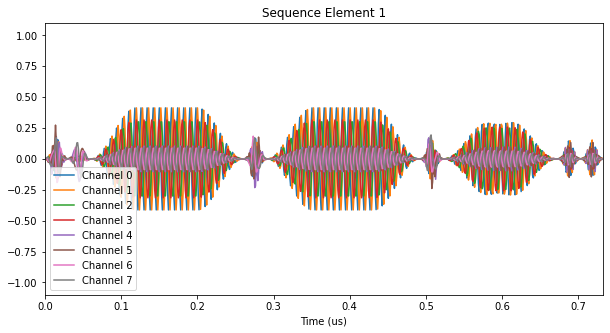

In [13]:
# Construct parallel ZZ-SWAP circuits
circuit1 = qiskit.QuantumCircuit(4)
circuit1.append(qiskit_superstaq.ZZSwapGate(2.5), [0, 1])
circuit1.append(qiskit_superstaq.ZZSwapGate(2.5), [2, 3])

circuit2 = qiskit.QuantumCircuit(4)
circuit2.append(qiskit_superstaq.ZZSwapGate(1.5), [0, 1])
circuit2.append(qiskit_superstaq.ZZSwapGate(1.5), [2, 3])


print("Input 1:")
print(circuit1)

print("\nInput 2:")
print(circuit2)


# Submit to Superstaq
compiler_output = provider.aqt_compile([circuit1, circuit2])


# Print compiled circuits and pulse sequences
print("\n\nOutput 1:")
print(compiler_output.circuits[0].draw(fold=-1))

print("\nOutput 2:")
print(compiler_output.circuits[1].draw(fold=140))

compiler_output.seq.plot(element=0)
compiler_output.seq.plot(element=1);

### Qiskit integration

This flexibility allows for simple integration with Qiskit's built-in experiments and circuits. Here we use Qiskit to generate a randomized quantum volume circuit; note that Superstaq efficiently routes the circuit to AQT's qubits and connectivity, decomposes and optimizes the resulting circuit (including any SWAP gates required for routing), and again aligns and merges CZ gates to use AQT's parallel calibration:

                                                                                                                                           »
q_0: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                                                           »
q_1: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                                                           »
q_2: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                                                           »
q_3: ────────

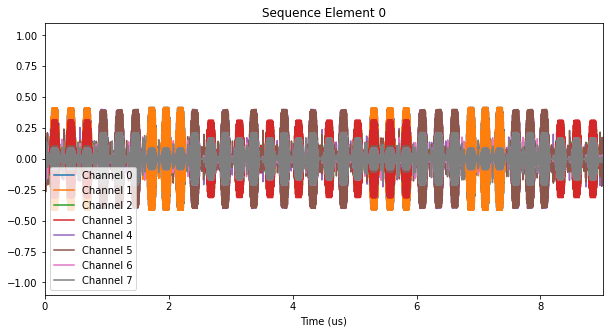

In [14]:
# Generate a quantum volume circuit
circuit = qiskit.circuit.library.QuantumVolume(4, seed=100)
circuit = qiskit.transpile(circuit, basis_gates=["u1", "u2", "u3", "cx"], optimization_level=3)

# Compile with Superstaq
compiler_output = provider.aqt_compile(circuit)

# Print the compiled circuit and pulse sequence
print(compiler_output.circuit.draw(fold=140))
compiler_output.seq.plot(element=0);

## Equivalent circuit averaging (ECA)

Superstaq provides an additional second endpoint for equivalent circuit averaging (also introduced in [1]). Using `aqt_compile_eca`, a single input circuit can be compiled into a set of physically distinct but logically equivalent pulse sequences

### Single-qubit gates (two possible decompositions)

Arbitrary SU(2) operations can be implemented on AQT using two Rx(π/2) pulses. Two such decompositions exist, which will be selected at random using `aqt_compile_eca`:



Equivalent circuit 1:
                                                  
q_0: ─────────────────────────────────────────────
                                                  
q_1: ─────────────────────────────────────────────
                                                  
q_2: ─────────────────────────────────────────────
                                                  
q_3: ─────────────────────────────────────────────
                                                  
q_4: ─────────────────────────────────────────────
     ┌───────┐┌─────────┐┌────────────┐┌─────────┐
q_5: ┤ Rz(π) ├┤ Rx(π/2) ├┤ Rz(1.9116) ├┤ Rx(π/2) ├
     └───────┘└─────────┘└────────────┘└─────────┘
q_6: ─────────────────────────────────────────────
                                                  
q_7: ─────────────────────────────────────────────
                                                  


Equivalent circuit 2:
                                                  
q_0: ─────────────────────────────

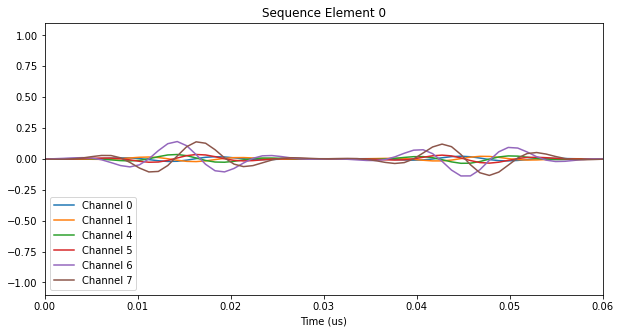

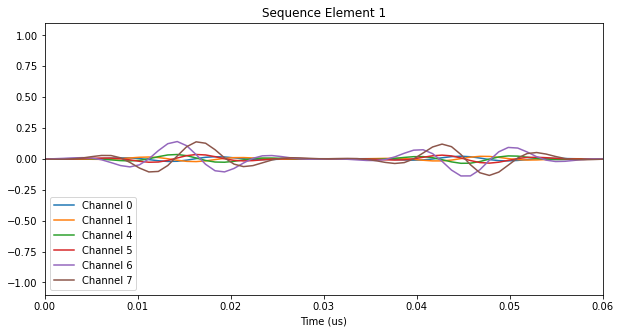

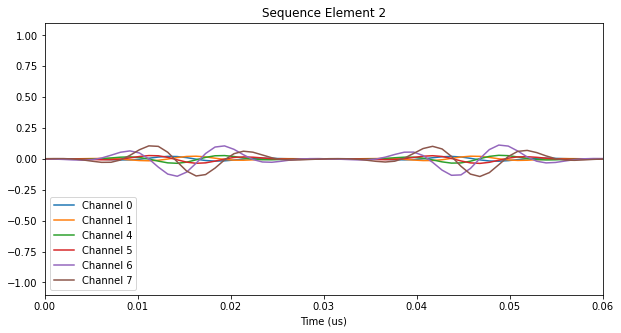

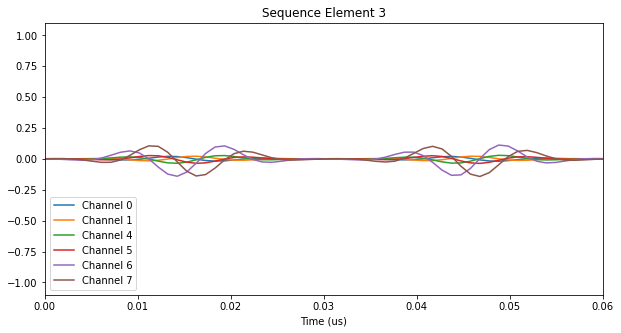

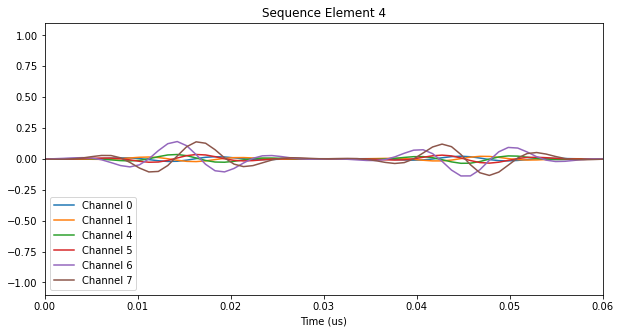

In [15]:
# Construct a circuit with a single one-qubit gate
circuit = qiskit.QuantumCircuit(4)
circuit.ry(1.23, 0)


# Use Superstaq to generate 5 equivalent circuits using ECA compilation
compiler_output = provider.aqt_compile_eca(circuit, num_equivalent_circuits=5, random_seed=1234)


# Print the equivalent circuits and pulse sequences
for i in range(5):
    print(f"\n\nEquivalent circuit {i+1}:")
    print(compiler_output.circuits[i])
    compiler_output.seq.plot(element=i)

### ZZ-SWAP



Equivalent circuit 1:
                                                                                                               »
q_0: ──────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                               »
q_1: ──────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                               »
q_2: ──────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                               »
q_3: ──────────────────────────────────────────────────────────────────────────────────────────────────────────»
      ┌───────────┐ ┌─────────┐                                        ┌



Equivalent circuit 5:
                                                                                                                     »
q_0: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                                     »
q_1: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                                     »
q_2: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                                     »
q_3: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
     ┌─────────────┐┌───

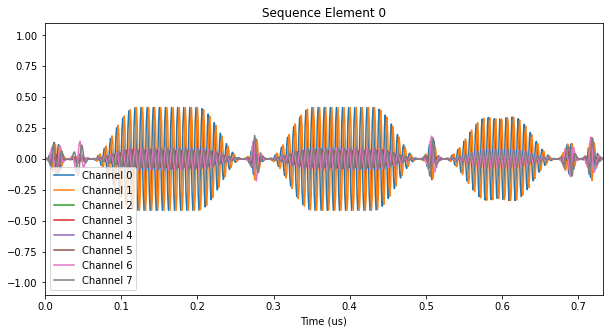

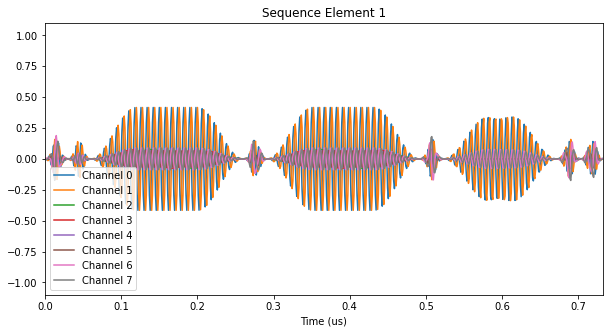

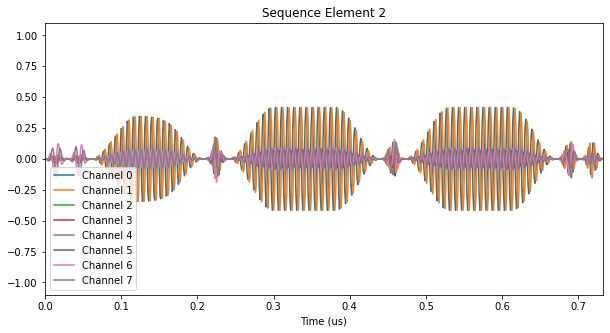

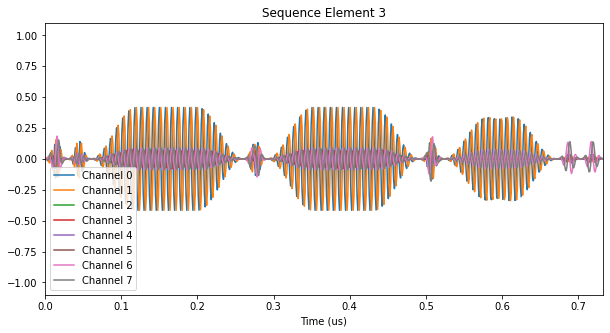

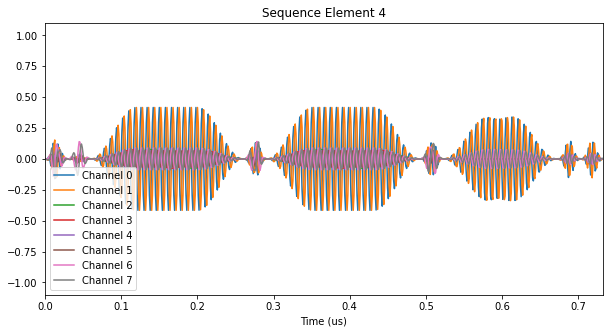

In [16]:
# Construct a ZZ-SWAP circuit which allows for the CS decomposition
circuit = qiskit.QuantumCircuit(4)
circuit.append(qiskit_superstaq.ZZSwapGate(1.23), [0, 1])


# Use Superstaq to generate 5 equivalent circuits using ECA compilation
compiler_output = provider.aqt_compile_eca(circuit, num_equivalent_circuits=5, random_seed=12345)


# Print the equivalent circuits and pulse sequences
for i in range(5):
    print(f"\n\nEquivalent circuit {i+1}:")
    print(compiler_output.circuits[i].draw(fold=120))
    compiler_output.seq.plot(element=i)

Input:
                      
q_0: ─────────────────
                      
q_1: ─────────────────
                      
q_2: ─────────────────
                      
q_3: ─────────────────
     ┌───────────────┐
q_4: ┤0              ├
     │  Zzswap(0.23) │
q_5: ┤1              ├
     ├───────────────┤
q_6: ┤0              ├
     │  Zzswap(0.23) │
q_7: ┤1              ├
     └───────────────┘


Equivalent circuit 1:
                                                                                                                    »
q_0: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                                    »
q_1: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                          

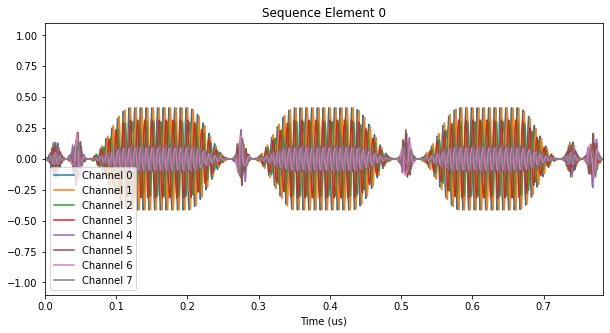

In [17]:
# Construct a circuit with parallel ZZ-SWAP gates (this time using the CZ decomposition):
circuit = qiskit.QuantumCircuit(8)
circuit.append(qiskit_superstaq.ZZSwapGate(0.23), [4, 5])
circuit.append(qiskit_superstaq.ZZSwapGate(0.23), [6, 7])
print("Input:")
print(circuit)


# Use Superstaq to generate 5 equivalent circuits using ECA compilation
compiler_output = provider.aqt_compile_eca(circuit, num_equivalent_circuits=5, random_seed=12345)


# Print the equivalent circuits
for i in range(5):
    print(f"\n\nEquivalent circuit {i+1}:")
    print(compiler_output.circuits[i].draw(fold=120))

compiler_output.seq.plot(element=0);

### Arbitrary circuits

Input circuit:
          ┌───┐               ┌───┐     ┌───┐          ┌───┐┌───┐                       
q_0: ─────┤ X ├────────────■──┤ H ├─────┤ X ├──■───────┤ X ├┤ Y ├───────────────────────
     ┌───┐└─┬─┘            │  └───┘┌───┐└─┬─┘┌─┴─┐┌───┐└─┬─┘├───┤   ┌───┐┌───┐     ┌───┐
q_1: ┤ S ├──■──────────────┼───────┤ X ├──┼──┤ X ├┤ H ├──■──┤ H ├─X─┤ X ├┤ H ├──■──┤ Z ├
     ├───┤          ┌───┐  │  ┌───┐└─┬─┘  │  ├───┤└───┘     └───┘ │ └─┬─┘└───┘┌─┴─┐└───┘
q_2: ┤ H ├──────────┤ X ├──┼──┤ H ├──┼────■──┤ H ├────────────────X───■───────┤ X ├─────
     ├───┤┌───┐┌───┐└─┬─┘┌─┴─┐└───┘  │  ┌───┐└───┘                            └───┘     
q_3: ┤ S ├┤ H ├┤ S ├──■──┤ X ├───────■──┤ X ├───────────────────────────────────────────
     └───┘└───┘└───┘     └───┘          └───┘                                           


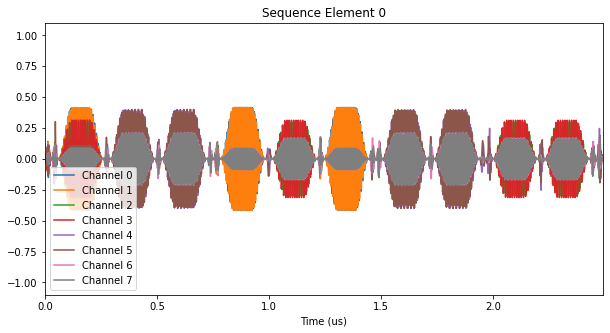

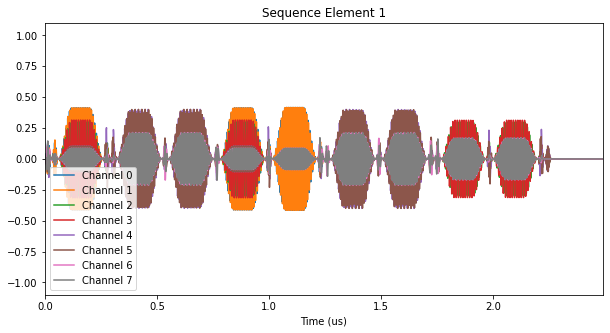

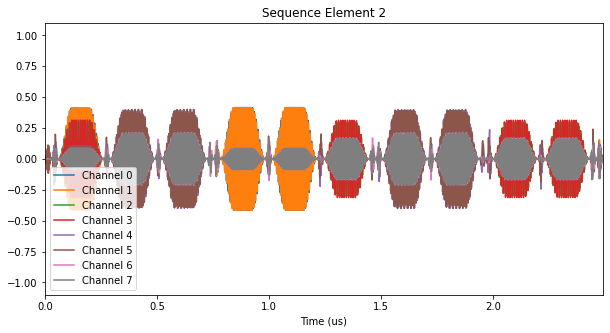

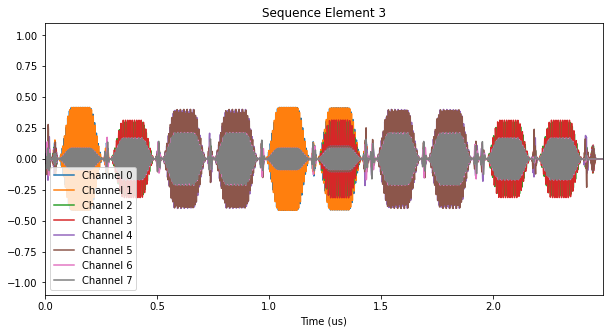

In [18]:
# Generate a random clifford circuit
circuit = qiskit.quantum_info.random_clifford(4, seed=1234).to_circuit()

print("Input circuit:")
print(circuit.draw(fold=-1))


# Use Superstaq to generate equivalent circuits using ECA compilation
compiler_output = provider.aqt_compile_eca(circuit, num_equivalent_circuits=4, random_seed=123)


# Print the logically-equivalent pulse sequences
for i in range(4):
    compiler_output.seq.plot(element=i)

### Other circuits using CS/CSd decompositions

In [19]:
# SQRT-ISWAP
circuit = qiskit.QuantumCircuit(4)
circuit.append(qiskit.circuit.library.XXPlusYYGate(π / 2), [0, 1])
print("Input:")
print(circuit)


# Use Superstaq to generate equivalent circuits using ECA compilation
compiler_output = provider.aqt_compile_eca(circuit, num_equivalent_circuits=5, random_seed=1234)


# Print the equivalent circuits and pulse sequences
for i in range(5):
    print(f"\n\nEquivalent circuit {i+1}:")
    print(compiler_output.circuits[i].draw(fold=-1))

Input:
     ┌─────────────────┐
q_0: ┤0                ├
     │  {XX+YY}(π/2,0) │
q_1: ┤1                ├
     └─────────────────┘
q_2: ───────────────────
                        
q_3: ───────────────────
                        


Equivalent circuit 1:
                                                                                                                              
q_0: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                              
q_1: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                              
q_2: ────────────────────────────────────────────────────────────────────────────────────────────────────────

In [20]:
# Parallel controlled rotations
circuit = qiskit.QuantumCircuit(8)
circuit.crx(5 * π / 7, 5, 4)
circuit.cry(7 * π / 5, 7, 6)

print("Input:")
print(circuit)


# Use Superstaq to generate equivalent circuits using ECA compilation
compiler_output = provider.aqt_compile_eca(circuit, num_equivalent_circuits=4, random_seed=1234)


# Print the equivalent circuits and pulse sequences
for i in range(4):
    print(f"\n\nEquivalent circuit {i+1}:")
    print(compiler_output.circuits[i].draw(fold=-1))

Input:
                 
q_0: ────────────
                 
q_1: ────────────
                 
q_2: ────────────
                 
q_3: ────────────
     ┌──────────┐
q_4: ┤ Rx(5π/7) ├
     └────┬─────┘
q_5: ─────■──────
     ┌──────────┐
q_6: ┤ Ry(7π/5) ├
     └────┬─────┘
q_7: ─────■──────
                 


Equivalent circuit 1:
                                                                                                                                                                                                                                         
q_0: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                   